In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'xs_ultra_tiny_precision_weighted_save/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Ultra Tiny. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

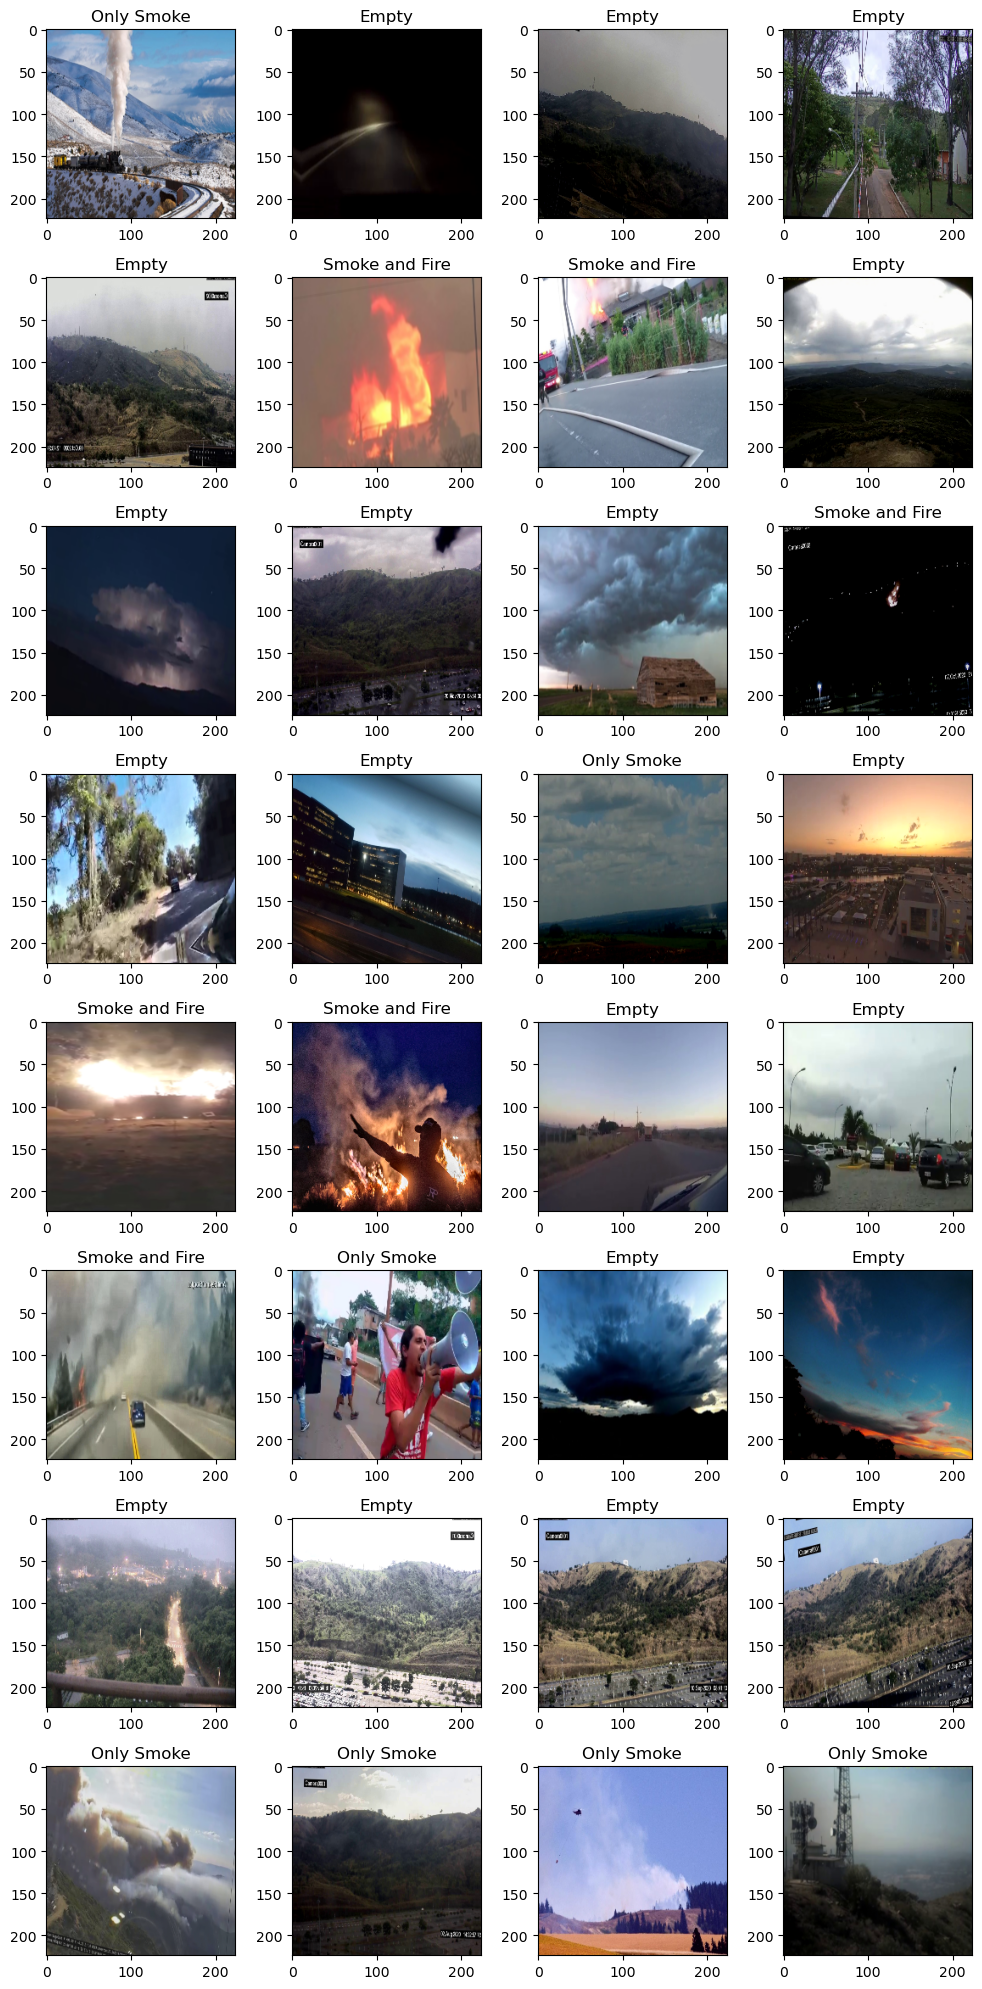

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 75 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.2539,  0.3916],
        [-0.1938,  0.3717],
        [-0.1853,  0.4813],
        [-0.2383,  0.4619]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_bed_classifier.pt') 

        if best_smoke_precision < v_pre[0].detach().to('cpu'):
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_bed_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 18:53:43

Initializing Weights

=== EPOCH 0/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.474      |36.459      |31.015      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.613      |36.147      |24.467      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.742 - Recall: 0.563 - Accuracy: 0.836 - F1: 0.640

Saving model with new best validation loss: 60.613

=== EPOCH 1/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.780      |35.673      |26.107      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.712      |34.609      |23.102      

SMOKE -> Precision: 0.619 - Recall: 0.236 - Accuracy: 0.562 - F1: 0.342
FIRE -> Precision: 0.775 - Recall: 0.635 - Accuracy: 0.858 - F1: 0.698

Saving model with new best validation loss: 57.712

Saving model with new best smoke precision: 0.619

=== EPOCH 2/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.238      |34.650      |24.588      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.980      |33.615      |21.365      

SMOKE -> Precision: 0.725 - Recall: 0.476 - Accuracy: 0.661 - F1: 0.575
FIRE -> Precision: 0.759 - Recall: 0.723 - Accuracy: 0.869 - F1: 0.740

Saving model with new best validation loss: 54.980

Saving model with new best smoke precision: 0.725

=== EPOCH 3/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.423      |33.547      |22.876      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.556      |32.338      |20.218      

SMOKE -> Precision: 0.789 - Recall: 0.390 - Accuracy: 0.656 - F1: 0.522
FIRE -> Precision: 0.784 - Recall: 0.740 - Accuracy: 0.880 - F1: 0.761

Saving model with new best validation loss: 52.556

Saving model with new best smoke precision: 0.789

=== EPOCH 4/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.997      |32.924      |21.073      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.964      |30.667      |17.296      

SMOKE -> Precision: 0.778 - Recall: 0.469 - Accuracy: 0.680 - F1: 0.585
FIRE -> Precision: 0.795 - Recall: 0.766 - Accuracy: 0.888 - F1: 0.780

Saving model with new best validation loss: 47.964

=== EPOCH 5/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.920      |32.250      |19.670      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.504      |30.625      |16.879      

SMOKE -> Precision: 0.799 - Recall: 0.404 - Accuracy: 0.664 - F1: 0.537
FIRE -> Precision: 0.816 - Recall: 0.733 - Accuracy: 0.888 - F1: 0.773

Saving model with new best validation loss: 47.504

Saving model with new best smoke precision: 0.799

=== EPOCH 6/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.782      |31.449      |18.333      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.624      |29.348      |15.275      

SMOKE -> Precision: 0.780 - Recall: 0.518 - Accuracy: 0.698 - F1: 0.623
FIRE -> Precision: 0.851 - Recall: 0.748 - Accuracy: 0.901 - F1: 0.796

Saving model with new best validation loss: 44.624

=== EPOCH 7/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.487      |30.832      |17.656      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.033      |29.105      |13.928      

SMOKE -> Precision: 0.728 - Recall: 0.734 - Accuracy: 0.740 - F1: 0.731
FIRE -> Precision: 0.809 - Recall: 0.870 - Accuracy: 0.913 - F1: 0.839

Saving model with new best validation loss: 43.033

=== EPOCH 8/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.086      |30.132      |16.954      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.111      |27.700      |13.411      

SMOKE -> Precision: 0.848 - Recall: 0.447 - Accuracy: 0.695 - F1: 0.585
FIRE -> Precision: 0.903 - Recall: 0.794 - Accuracy: 0.924 - F1: 0.845

Saving model with new best validation loss: 41.111

Saving model with new best smoke precision: 0.848

=== EPOCH 9/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.702      |29.381      |16.321      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.517      |26.243      |12.274      

SMOKE -> Precision: 0.792 - Recall: 0.649 - Accuracy: 0.749 - F1: 0.714
FIRE -> Precision: 0.868 - Recall: 0.850 - Accuracy: 0.928 - F1: 0.859

Saving model with new best validation loss: 38.517

=== EPOCH 10/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.594      |29.015      |15.578      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.500      |25.697      |11.803      

SMOKE -> Precision: 0.810 - Recall: 0.646 - Accuracy: 0.757 - F1: 0.718
FIRE -> Precision: 0.851 - Recall: 0.890 - Accuracy: 0.931 - F1: 0.870

Saving model with new best validation loss: 37.500

=== EPOCH 11/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.619      |28.589      |15.030      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.007      |25.327      |11.680      

SMOKE -> Precision: 0.803 - Recall: 0.720 - Accuracy: 0.781 - F1: 0.760
FIRE -> Precision: 0.864 - Recall: 0.868 - Accuracy: 0.930 - F1: 0.866

Saving model with new best validation loss: 37.007

=== EPOCH 12/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.678      |27.963      |14.715      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.449      |25.363      |12.085      

SMOKE -> Precision: 0.745 - Recall: 0.857 - Accuracy: 0.790 - F1: 0.797
FIRE -> Precision: 0.849 - Recall: 0.912 - Accuracy: 0.935 - F1: 0.879

=== EPOCH 13/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.945      |27.490      |14.455      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.744      |23.968      |10.776      

SMOKE -> Precision: 0.793 - Recall: 0.795 - Accuracy: 0.802 - F1: 0.794
FIRE -> Precision: 0.885 - Recall: 0.877 - Accuracy: 0.939 - F1: 0.881

Saving model with new best validation loss: 34.744

=== EPOCH 14/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.826      |27.284      |14.542      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.684      |23.307      |11.377      

SMOKE -> Precision: 0.857 - Recall: 0.635 - Accuracy: 0.774 - F1: 0.730
FIRE -> Precision: 0.932 - Recall: 0.819 - Accuracy: 0.938 - F1: 0.872

Saving model with new best validation loss: 34.684

Saving model with new best smoke precision: 0.857

=== EPOCH 15/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.497      |26.602      |13.895      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.928      |22.553      |10.375      

SMOKE -> Precision: 0.840 - Recall: 0.712 - Accuracy: 0.796 - F1: 0.771
FIRE -> Precision: 0.891 - Recall: 0.877 - Accuracy: 0.940 - F1: 0.884

Saving model with new best validation loss: 32.928

=== EPOCH 16/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.426      |26.420      |14.006      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.570      |22.560      |11.010      

SMOKE -> Precision: 0.905 - Recall: 0.585 - Accuracy: 0.771 - F1: 0.711
FIRE -> Precision: 0.938 - Recall: 0.838 - Accuracy: 0.944 - F1: 0.885

Saving model with new best smoke precision: 0.905

=== EPOCH 17/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.697      |26.063      |13.634      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.169      |22.708      |10.461      

SMOKE -> Precision: 0.821 - Recall: 0.738 - Accuracy: 0.796 - F1: 0.777
FIRE -> Precision: 0.876 - Recall: 0.900 - Accuracy: 0.941 - F1: 0.888

=== EPOCH 18/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.382      |25.996      |13.386      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.768      |21.901      |10.867      

SMOKE -> Precision: 0.874 - Recall: 0.667 - Accuracy: 0.793 - F1: 0.756
FIRE -> Precision: 0.944 - Recall: 0.823 - Accuracy: 0.942 - F1: 0.880

Saving model with new best validation loss: 32.768

=== EPOCH 19/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.962      |25.673      |13.289      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.372      |22.734      |9.638       

SMOKE -> Precision: 0.788 - Recall: 0.833 - Accuracy: 0.812 - F1: 0.810
FIRE -> Precision: 0.899 - Recall: 0.900 - Accuracy: 0.948 - F1: 0.900

Saving model with new best validation loss: 32.372

=== EPOCH 20/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.467      |25.395      |13.073      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.144      |21.132      |10.012      

SMOKE -> Precision: 0.814 - Recall: 0.835 - Accuracy: 0.829 - F1: 0.824
FIRE -> Precision: 0.864 - Recall: 0.922 - Accuracy: 0.942 - F1: 0.892

Saving model with new best validation loss: 31.144

=== EPOCH 21/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.085      |25.142      |12.943      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.939      |20.422      |9.517       

SMOKE -> Precision: 0.841 - Recall: 0.791 - Accuracy: 0.827 - F1: 0.815
FIRE -> Precision: 0.908 - Recall: 0.885 - Accuracy: 0.947 - F1: 0.896

Saving model with new best validation loss: 29.939

=== EPOCH 22/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.679      |24.730      |12.949      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.525      |22.159      |10.366      

SMOKE -> Precision: 0.799 - Recall: 0.836 - Accuracy: 0.820 - F1: 0.817
FIRE -> Precision: 0.839 - Recall: 0.932 - Accuracy: 0.936 - F1: 0.883

=== EPOCH 23/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.260      |24.708      |12.551      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.418      |21.089      |9.330       

SMOKE -> Precision: 0.804 - Recall: 0.872 - Accuracy: 0.836 - F1: 0.837
FIRE -> Precision: 0.890 - Recall: 0.915 - Accuracy: 0.949 - F1: 0.902

=== EPOCH 24/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.594      |24.155      |12.439      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.351      |19.927      |9.423       

SMOKE -> Precision: 0.823 - Recall: 0.843 - Accuracy: 0.837 - F1: 0.833
FIRE -> Precision: 0.875 - Recall: 0.929 - Accuracy: 0.947 - F1: 0.901

Saving model with new best validation loss: 29.351

=== EPOCH 25/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.264      |24.034      |12.229      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.675      |20.169      |10.506      

SMOKE -> Precision: 0.815 - Recall: 0.854 - Accuracy: 0.836 - F1: 0.834
FIRE -> Precision: 0.841 - Recall: 0.939 - Accuracy: 0.938 - F1: 0.887

=== EPOCH 26/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.001      |23.860      |12.141      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.689      |19.415      |9.274       

SMOKE -> Precision: 0.847 - Recall: 0.815 - Accuracy: 0.840 - F1: 0.831
FIRE -> Precision: 0.924 - Recall: 0.889 - Accuracy: 0.952 - F1: 0.906

Saving model with new best validation loss: 28.689

=== EPOCH 27/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.899      |23.792      |12.107      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.011      |19.036      |8.976       

SMOKE -> Precision: 0.862 - Recall: 0.819 - Accuracy: 0.850 - F1: 0.840
FIRE -> Precision: 0.899 - Recall: 0.910 - Accuracy: 0.950 - F1: 0.904

Saving model with new best validation loss: 28.011

=== EPOCH 28/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.441      |23.512      |11.929      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.493      |19.452      |9.040       

SMOKE -> Precision: 0.859 - Recall: 0.789 - Accuracy: 0.836 - F1: 0.822
FIRE -> Precision: 0.921 - Recall: 0.877 - Accuracy: 0.948 - F1: 0.898

=== EPOCH 29/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.993      |23.299      |11.694      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.017      |18.398      |8.619       

SMOKE -> Precision: 0.877 - Recall: 0.795 - Accuracy: 0.848 - F1: 0.834
FIRE -> Precision: 0.934 - Recall: 0.888 - Accuracy: 0.955 - F1: 0.910

Saving model with new best validation loss: 27.017

=== EPOCH 30/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.212      |23.313      |11.899      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.822      |18.296      |8.526       

SMOKE -> Precision: 0.878 - Recall: 0.806 - Accuracy: 0.853 - F1: 0.840
FIRE -> Precision: 0.930 - Recall: 0.909 - Accuracy: 0.959 - F1: 0.919

Saving model with new best validation loss: 26.822

=== EPOCH 31/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.103      |23.294      |11.809      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.027      |19.137      |8.890       

SMOKE -> Precision: 0.833 - Recall: 0.871 - Accuracy: 0.854 - F1: 0.851
FIRE -> Precision: 0.895 - Recall: 0.923 - Accuracy: 0.952 - F1: 0.909

=== EPOCH 32/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.277      |22.883      |11.394      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.480      |18.973      |8.507       

SMOKE -> Precision: 0.899 - Recall: 0.720 - Accuracy: 0.826 - F1: 0.799
FIRE -> Precision: 0.938 - Recall: 0.891 - Accuracy: 0.957 - F1: 0.914

=== EPOCH 33/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.294      |22.732      |11.561      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.419      |18.221      |8.197       

SMOKE -> Precision: 0.843 - Recall: 0.863 - Accuracy: 0.857 - F1: 0.853
FIRE -> Precision: 0.945 - Recall: 0.882 - Accuracy: 0.956 - F1: 0.912

Saving model with new best validation loss: 26.419

=== EPOCH 34/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.621      |22.551      |11.070      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.932      |17.614      |8.318       

SMOKE -> Precision: 0.890 - Recall: 0.792 - Accuracy: 0.853 - F1: 0.838
FIRE -> Precision: 0.913 - Recall: 0.905 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 25.932

=== EPOCH 35/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.196      |21.940      |11.256      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.626      |18.429      |9.197       

SMOKE -> Precision: 0.901 - Recall: 0.746 - Accuracy: 0.838 - F1: 0.816
FIRE -> Precision: 0.941 - Recall: 0.870 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 36/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.724      |22.343      |11.381      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.995      |17.887      |9.108       

SMOKE -> Precision: 0.844 - Recall: 0.876 - Accuracy: 0.863 - F1: 0.860
FIRE -> Precision: 0.855 - Recall: 0.949 - Accuracy: 0.945 - F1: 0.899

=== EPOCH 37/74 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.616      |22.273      |11.343      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.144      |17.767      |8.377       

SMOKE -> Precision: 0.880 - Recall: 0.802 - Accuracy: 0.852 - F1: 0.839
FIRE -> Precision: 0.918 - Recall: 0.912 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 38/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.477      |21.545      |10.932      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.538      |17.097      |8.441       

SMOKE -> Precision: 0.862 - Recall: 0.868 - Accuracy: 0.869 - F1: 0.865
FIRE -> Precision: 0.900 - Recall: 0.922 - Accuracy: 0.953 - F1: 0.911

Saving model with new best validation loss: 25.538

=== EPOCH 39/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.082      |21.432      |10.649      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.74it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.416      |17.253      |10.163      

SMOKE -> Precision: 0.884 - Recall: 0.812 - Accuracy: 0.858 - F1: 0.847
FIRE -> Precision: 0.967 - Recall: 0.807 - Accuracy: 0.943 - F1: 0.880

=== EPOCH 40/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.038      |21.379      |10.659      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.360      |16.745      |8.615       

SMOKE -> Precision: 0.868 - Recall: 0.861 - Accuracy: 0.870 - F1: 0.865
FIRE -> Precision: 0.884 - Recall: 0.923 - Accuracy: 0.948 - F1: 0.903

Saving model with new best validation loss: 25.360

=== EPOCH 41/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.683      |21.099      |10.583      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.622      |16.548      |8.075       

SMOKE -> Precision: 0.886 - Recall: 0.840 - Accuracy: 0.871 - F1: 0.862
FIRE -> Precision: 0.922 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 24.622

=== EPOCH 42/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.319      |20.870      |10.449      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.644      |16.210      |8.433       

SMOKE -> Precision: 0.915 - Recall: 0.798 - Accuracy: 0.867 - F1: 0.853
FIRE -> Precision: 0.943 - Recall: 0.887 - Accuracy: 0.957 - F1: 0.914

Saving model with new best smoke precision: 0.915

=== EPOCH 43/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.811      |20.309      |10.502      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.639      |16.471      |8.168       

SMOKE -> Precision: 0.895 - Recall: 0.813 - Accuracy: 0.864 - F1: 0.852
FIRE -> Precision: 0.932 - Recall: 0.900 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 44/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.732      |20.351      |10.380      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.248      |15.848      |8.400       

SMOKE -> Precision: 0.896 - Recall: 0.825 - Accuracy: 0.870 - F1: 0.859
FIRE -> Precision: 0.887 - Recall: 0.937 - Accuracy: 0.953 - F1: 0.911

Saving model with new best validation loss: 24.248

=== EPOCH 45/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.958      |20.469      |10.489      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 21.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.113      |17.109      |8.003       

SMOKE -> Precision: 0.908 - Recall: 0.790 - Accuracy: 0.860 - F1: 0.844
FIRE -> Precision: 0.930 - Recall: 0.905 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 46/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.565      |20.437      |10.128      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.158      |16.187      |7.970       

SMOKE -> Precision: 0.857 - Recall: 0.906 - Accuracy: 0.882 - F1: 0.881
FIRE -> Precision: 0.895 - Recall: 0.931 - Accuracy: 0.954 - F1: 0.913

Saving model with new best validation loss: 24.158

=== EPOCH 47/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.069      |19.825      |10.244      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.944      |15.837      |8.107       

SMOKE -> Precision: 0.887 - Recall: 0.852 - Accuracy: 0.876 - F1: 0.869
FIRE -> Precision: 0.938 - Recall: 0.900 - Accuracy: 0.959 - F1: 0.919

Saving model with new best validation loss: 23.944

=== EPOCH 48/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.413      |20.256      |10.157      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.280      |16.186      |8.094       

SMOKE -> Precision: 0.873 - Recall: 0.868 - Accuracy: 0.876 - F1: 0.870
FIRE -> Precision: 0.905 - Recall: 0.932 - Accuracy: 0.957 - F1: 0.918

=== EPOCH 49/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.614      |20.130      |10.484      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.549      |15.465      |8.084       

SMOKE -> Precision: 0.898 - Recall: 0.840 - Accuracy: 0.877 - F1: 0.868
FIRE -> Precision: 0.894 - Recall: 0.941 - Accuracy: 0.956 - F1: 0.917

Saving model with new best validation loss: 23.549

=== EPOCH 50/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.095      |19.858      |10.237      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.098      |18.272      |7.826       

SMOKE -> Precision: 0.939 - Recall: 0.680 - Accuracy: 0.825 - F1: 0.789
FIRE -> Precision: 0.936 - Recall: 0.908 - Accuracy: 0.960 - F1: 0.922

Saving model with new best smoke precision: 0.939

=== EPOCH 51/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.140      |19.888      |10.252      



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.561      |14.784      |7.777       

SMOKE -> Precision: 0.899 - Recall: 0.851 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.942 - Recall: 0.890 - Accuracy: 0.957 - F1: 0.915

Saving model with new best validation loss: 22.561

=== EPOCH 52/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.802      |19.855      |9.946       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.401      |15.815      |7.585       

SMOKE -> Precision: 0.909 - Recall: 0.802 - Accuracy: 0.866 - F1: 0.852
FIRE -> Precision: 0.944 - Recall: 0.908 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 53/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.679      |19.819      |9.860       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.694      |15.444      |8.250       

SMOKE -> Precision: 0.888 - Recall: 0.868 - Accuracy: 0.884 - F1: 0.878
FIRE -> Precision: 0.899 - Recall: 0.941 - Accuracy: 0.958 - F1: 0.920

=== EPOCH 54/74 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.506      |19.536      |9.970       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.833      |15.532      |7.302       

SMOKE -> Precision: 0.854 - Recall: 0.915 - Accuracy: 0.884 - F1: 0.884
FIRE -> Precision: 0.937 - Recall: 0.900 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 55/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.057      |19.426      |9.631       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.502      |14.733      |8.769       

SMOKE -> Precision: 0.916 - Recall: 0.840 - Accuracy: 0.886 - F1: 0.876
FIRE -> Precision: 0.956 - Recall: 0.865 - Accuracy: 0.955 - F1: 0.908

=== EPOCH 56/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.406      |18.886      |9.519       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.221      |15.487      |7.733       

SMOKE -> Precision: 0.901 - Recall: 0.824 - Accuracy: 0.872 - F1: 0.861
FIRE -> Precision: 0.893 - Recall: 0.935 - Accuracy: 0.954 - F1: 0.914

=== EPOCH 57/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.043      |18.713      |9.330       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.256      |14.915      |7.341       

SMOKE -> Precision: 0.883 - Recall: 0.881 - Accuracy: 0.887 - F1: 0.882
FIRE -> Precision: 0.921 - Recall: 0.923 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 22.256

=== EPOCH 58/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.536      |18.999      |9.537       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.444      |14.992      |7.452       

SMOKE -> Precision: 0.930 - Recall: 0.809 - Accuracy: 0.879 - F1: 0.865
FIRE -> Precision: 0.920 - Recall: 0.931 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 59/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.288      |19.033      |9.255       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.797      |14.317      |7.480       

SMOKE -> Precision: 0.881 - Recall: 0.904 - Accuracy: 0.895 - F1: 0.892
FIRE -> Precision: 0.901 - Recall: 0.940 - Accuracy: 0.958 - F1: 0.920

Saving model with new best validation loss: 21.797

=== EPOCH 60/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.042      |18.711      |9.331       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.130      |14.693      |7.438       

SMOKE -> Precision: 0.908 - Recall: 0.839 - Accuracy: 0.882 - F1: 0.872
FIRE -> Precision: 0.911 - Recall: 0.935 - Accuracy: 0.960 - F1: 0.923

=== EPOCH 61/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.025      |18.735      |9.290       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.253      |13.876      |7.377       

SMOKE -> Precision: 0.898 - Recall: 0.875 - Accuracy: 0.892 - F1: 0.887
FIRE -> Precision: 0.918 - Recall: 0.931 - Accuracy: 0.961 - F1: 0.924

Saving model with new best validation loss: 21.253

=== EPOCH 62/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.768      |18.482      |9.286       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.058      |13.909      |7.149       

SMOKE -> Precision: 0.892 - Recall: 0.899 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.936 - Recall: 0.923 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 21.058

=== EPOCH 63/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.512      |18.370      |9.142       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.480      |15.032      |7.449       

SMOKE -> Precision: 0.920 - Recall: 0.819 - Accuracy: 0.879 - F1: 0.867
FIRE -> Precision: 0.925 - Recall: 0.931 - Accuracy: 0.962 - F1: 0.928

=== EPOCH 64/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.930      |18.444      |9.486       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.014      |14.102      |7.911       

SMOKE -> Precision: 0.923 - Recall: 0.840 - Accuracy: 0.889 - F1: 0.879
FIRE -> Precision: 0.963 - Recall: 0.887 - Accuracy: 0.962 - F1: 0.924

=== EPOCH 65/74 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.691      |18.320      |9.371       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.417      |14.144      |7.274       

SMOKE -> Precision: 0.896 - Recall: 0.889 - Accuracy: 0.897 - F1: 0.892
FIRE -> Precision: 0.911 - Recall: 0.942 - Accuracy: 0.961 - F1: 0.926

=== EPOCH 66/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.825      |17.649      |9.176       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.279      |13.203      |7.076       

SMOKE -> Precision: 0.911 - Recall: 0.886 - Accuracy: 0.904 - F1: 0.899
FIRE -> Precision: 0.924 - Recall: 0.931 - Accuracy: 0.962 - F1: 0.927

Saving model with new best validation loss: 20.279

=== EPOCH 67/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.782      |17.799      |8.983       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.963      |15.035      |7.928       

SMOKE -> Precision: 0.876 - Recall: 0.883 - Accuracy: 0.884 - F1: 0.879
FIRE -> Precision: 0.874 - Recall: 0.954 - Accuracy: 0.953 - F1: 0.913

=== EPOCH 68/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.793      |18.022      |8.771       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.196      |13.969      |7.227       

SMOKE -> Precision: 0.897 - Recall: 0.864 - Accuracy: 0.887 - F1: 0.880
FIRE -> Precision: 0.924 - Recall: 0.930 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 69/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.398      |17.520      |8.879       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.786      |13.629      |7.158       

SMOKE -> Precision: 0.914 - Recall: 0.843 - Accuracy: 0.886 - F1: 0.877
FIRE -> Precision: 0.913 - Recall: 0.939 - Accuracy: 0.961 - F1: 0.926

=== EPOCH 70/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.365      |17.562      |8.803       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.843      |13.294      |7.548       

SMOKE -> Precision: 0.912 - Recall: 0.868 - Accuracy: 0.896 - F1: 0.889
FIRE -> Precision: 0.891 - Recall: 0.948 - Accuracy: 0.956 - F1: 0.918

=== EPOCH 71/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.956      |17.237      |8.719       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.171      |13.130      |7.041       

SMOKE -> Precision: 0.925 - Recall: 0.852 - Accuracy: 0.896 - F1: 0.887
FIRE -> Precision: 0.952 - Recall: 0.920 - Accuracy: 0.967 - F1: 0.935

Saving model with new best validation loss: 20.171

=== EPOCH 72/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.815      |17.203      |8.611       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.297      |13.147      |7.150       

SMOKE -> Precision: 0.900 - Recall: 0.903 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.917 - Recall: 0.932 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 73/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.828      |17.215      |8.613       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.818      |12.669      |7.149       

SMOKE -> Precision: 0.907 - Recall: 0.900 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.912 - Recall: 0.944 - Accuracy: 0.962 - F1: 0.928

Saving model with new best validation loss: 19.818

=== EPOCH 74/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.675      |16.900      |8.775       



Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.462      |13.196      |7.266       

SMOKE -> Precision: 0.918 - Recall: 0.852 - Accuracy: 0.892 - F1: 0.884
FIRE -> Precision: 0.904 - Recall: 0.942 - Accuracy: 0.959 - F1: 0.923

***Script finished: 19:27:26

Time elapsed: 0:33:43.220609


# Confusion Matrix

In [20]:
smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

In [26]:
def get_conf_mtx(loader, model, device):

    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x) 
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        #yhat = torch.sigmoid(out.detach())
        yhat = out.detach() # La metrica entiende que son logits y aplica sigmoid
        smoke_conf_mtx_metric.update(yhat[..., 0], y[..., 0])
        fire_conf_mtx_metric.update(yhat[..., 1], y[..., 1])
    
    smoke_conf_mtx = smoke_conf_mtx_metric.compute()
    fire_conf_mtx = fire_conf_mtx_metric.compute()
    # smoke_conf_mtx_metric.reset()
    # fire_conf_mtx_metric.reset()
    
    return smoke_conf_mtx, fire_conf_mtx

In [27]:
smoke_conf_mtx, fire_conf_mtx = get_conf_mtx(loader=val_loader,
                                             model=model_trained,
                                             device=DEVICE)
print(smoke_conf_mtx)
print(fire_conf_mtx)

Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 20.07it/s]

tensor([[2069,  156],
        [ 306, 1757]], device='cuda:0')
tensor([[3067,  111],
        [  64, 1046]], device='cuda:0')


### Smoke confusion matrix

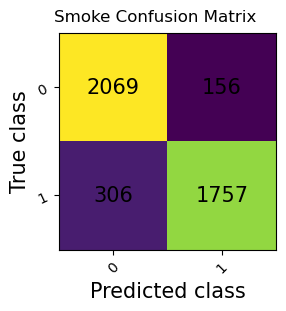

In [36]:
fig, ax = smoke_conf_mtx_metric.plot()
fig.suptitle("Smoke Confusion Matrix")
fig.set_size_inches(3,3)
fig.savefig("xs_ultra_tiny_precision_weighted_save/smoke_conf_mtx.png")

### Fire confusion matrix

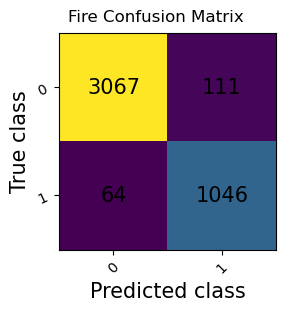

In [35]:
fig, ax = fire_conf_mtx_metric.plot()
fig.suptitle("Fire Confusion Matrix")
fig.set_size_inches(3,3)
fig.savefig("xs_ultra_tiny_precision_weighted_save/fire_conf_mtx.png")

# Confusion Matrix 4 classes

In [40]:
def get_conf_mtx_4_classes(loader, model, device):

    empty_row = np.zeros((4))
    smoke_row = np.zeros((4))
    fire_row = np.zeros((4))
    smoke_fire_row = np.zeros((4))  

    empty = torch.tensor([0, 0], dtype= torch.float32).to(device)
    smoke = torch.tensor([1, 0], dtype= torch.float32).to(device)
    fire = torch.tensor([0, 1], dtype= torch.float32).to(device)
    smoke_fire = torch.tensor([1, 1], dtype= torch.float32).to(device)
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x) 
        yhat = torch.round(torch.sigmoid(out.detach()))
        
        for i in range(x.shape[0]):
            # Empty class
            if torch.equal(y[i], empty):
                if torch.equal(yhat[i], empty):
                    empty_row[0] += 1
                elif torch.equal(yhat[i], smoke):
                    empty_row[1] += 1
                elif torch.equal(yhat[i], fire):
                    empty_row[2] += 1
                elif torch.equal(yhat[i], smoke_fire):
                    empty_row[3] += 1
                else:
                    print("Error")
            # Smoke class
            if torch.equal(y[i], smoke):
                if torch.equal(yhat[i], empty):
                    smoke_row[0] += 1
                elif torch.equal(yhat[i], smoke):
                    smoke_row[1] += 1
                elif torch.equal(yhat[i], fire):
                    smoke_row[2] += 1
                elif torch.equal(yhat[i], smoke_fire):
                    smoke_row[3] += 1
                else:
                    print("Error")
            # Fire class
            if torch.equal(y[i], fire):
                if torch.equal(yhat[i], empty):
                    fire_row[0] += 1
                elif torch.equal(yhat[i], smoke):
                    fire_row[1] += 1
                elif torch.equal(yhat[i], fire):
                    fire_row[2] += 1
                elif torch.equal(yhat[i], smoke_fire):
                    fire_row[3] += 1
                else:
                    print("Error")
            # Smoke and Fire class
            if torch.equal(y[i], smoke_fire):
                if torch.equal(yhat[i], empty):
                    smoke_fire_row[0] += 1
                elif torch.equal(yhat[i], smoke):
                    smoke_fire_row[1] += 1
                elif torch.equal(yhat[i], fire):
                    smoke_fire_row[2] += 1
                elif torch.equal(yhat[i], smoke_fire):
                    smoke_fire_row[3] += 1
                else:
                    print("Error")
    
    return np.stack((empty_row, smoke_row, fire_row, smoke_fire_row))

In [41]:
conf_mtx_4 = get_conf_mtx_4_classes(loader=val_loader, 
                                    model=model_trained,
                                    device=DEVICE)

Validating: 100%|███████████████████████████████| 67/67 [00:03<00:00, 19.75it/s]


In [42]:
print(conf_mtx_4)

[[1898.   71.   18.   18.]
 [ 246.  852.    3.   72.]
 [  16.    5.  137.   62.]
 [   9.   34.   48.  799.]]


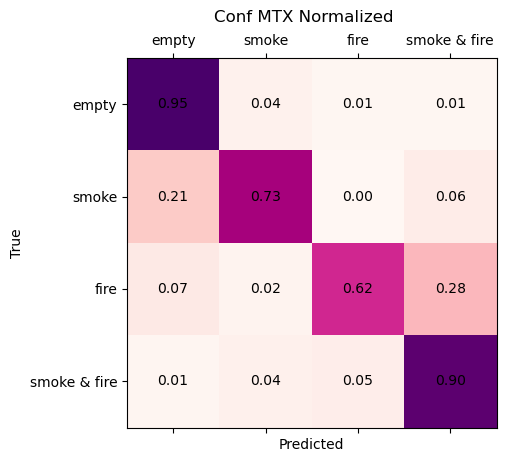

In [72]:
conf_mtx_4[0, ...] = conf_mtx_4[0, ...] / np.sum(conf_mtx_4[0, ...])
conf_mtx_4[1, ...] = conf_mtx_4[1, ...] / np.sum(conf_mtx_4[1, ...])
conf_mtx_4[2, ...] = conf_mtx_4[2, ...] / np.sum(conf_mtx_4[2, ...])
conf_mtx_4[3, ...] = conf_mtx_4[3, ...] / np.sum(conf_mtx_4[3, ...])
fig, ax = plt.subplots()
fig.suptitle('Conf MTX Normalized')
ax.matshow(conf_mtx_4, cmap='RdPu')
for (i, j), z in np.ndenumerate(conf_mtx_4):
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
#ax.matshow(conf_mtx_4, cmap='Blues')
#ax.set_xticklabels(['empty', 'smoke', 'fire', 'smoke & fire'])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_yticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
ax.set_xticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
plt.show()

# Plot Results

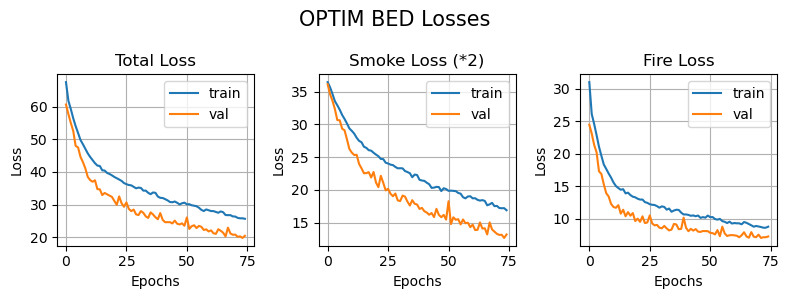

In [24]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss (*2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()